In [1]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)
library(ggrepel)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# 1. Load unpermuted network feature values

In [2]:
unperm_features_df <- read_tsv('../../data/feature-degree/ppi_feature_values.tsv') %>%
    filter(id_a != id_b & edge == 0) %>%
    mutate(degree_product = preferential_attachment) %>%
    gather('feature', 'value', adamic, jaccard, preferential_attachment, resource_allocation, rwr) %>%
    mutate(
        feature = feature %>% recode_factor(
            adamic = 'Adamic/Adar index',
            jaccard = 'Jaccard index',
            preferential_attachment = 'Preferential attachment\nindex',
            resource_allocation = 'Resource allocation\nindex',
            rwr = 'Random walk\nwith restart',
        )
    )

Parsed with column specification:
cols(
  id_a = col_double(),
  id_b = col_double(),
  edge = col_logical(),
  edge_prior = col_double(),
  adamic = col_double(),
  jaccard = col_double(),
  preferential_attachment = col_double(),
  resource_allocation = col_double(),
  rwr = col_double()
)


# 2. Plot unpermuted network feature/degree correlation

In [3]:
# Sample (for better scatter plotting)
features_df <- unperm_features_df %>%
    group_by(feature) %>%
    sample_n(10000)

# Compute correlations on the unsampled data
correlation_df <- unperm_features_df %>%
    group_by(feature) %>%
    summarize(correlation = cor(degree_product, value, method = 'pearson')) %>%
    ungroup() %>%
    mutate(label = sprintf(fmt = 'r = %.1f', correlation))

In [5]:
unperm_features_plot <- features_df %>%
    ggplot(aes(x = degree_product, y = value)) +
    geom_point(alpha = 0.3) +
    geom_text(data = correlation_df, aes(label = label), x = Inf, y = -Inf, vjust = -0.7, hjust = 1.1) +
    facet_wrap(vars(feature), scales = 'free', nrow = 1) +
    theme_zietzm() +
    theme(axis.text = element_blank(), axis.title = element_text(size = 12, color = 'black')) +
    xlab('Product of source and target degrees') +
    ylab('Feature value')

In [8]:
features_df %>% write_tsv("../../data/7.tsv")

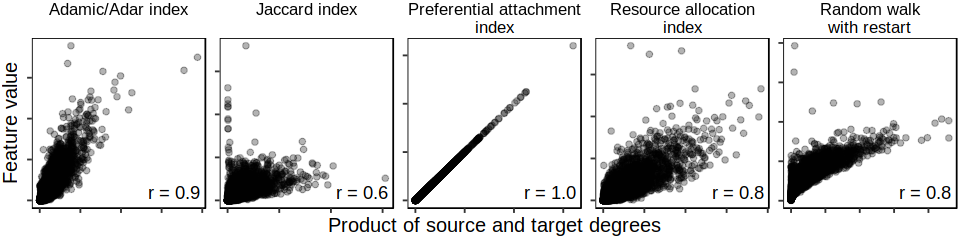

In [7]:
options(repr.plot.width=8, repr.plot.height=2)

ggsave(filename = '../../img/feature-degree.png', unperm_features_plot, width = 8, height = 2, dpi = 300)

unperm_features_plot